# Assignment 8 (continuation of assignment 7): Boosting
Only use the already imported library `numpy`, `matplotlib`, and the Python standard library. For the evaluation, you may also use scikit-learn (`sklearn`). Make sure that the dataset `df_arabica_clean.csv` is in the same directory as the notebook.

List your team members (name and matriculation number) and indicate whether you are a B.Sc. Data Science or other groups in the following cell:

==> *Write*
* *names*
* *matr. nr.*
* *study program*
* *B.Sc./M.Sc.*

*of all assignment group participants here. (double click here to edit)*

In [ ]:
# You are allowed to use the numpy package and the DecisionTreeClassifier.
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from typing import Tuple, Any
from numpy.typing import NDArray
from dateutil import parser

import pandas as pd
from sklearn.model_selection import train_test_split

countries = [
    "Taiwan",
    "Guatemala",
    "Colombia",
    "Honduras",
    "Thailand",
    "Ethiopia",
    "Brazil",
    "Costa Rica",
    "Nicaragua",
    "El Salvador",
]

feature_names = countries[:8] + [
    "Altitude",
    "Washed",
    "Pulped natural",
    "Natural",
    "Moisture Percentage",
    "Category One Defects",
    "Category Two Defects",
]
label_names = ["below average", "above average"]


def load_dataset(
    path: str,
) -> Tuple[NDArray[Any], NDArray[Any], NDArray[np.int64], NDArray[np.int64]]:
    # some of the preprocessing steps are taken from https://www.kaggle.com/code/tumpanjawat/coffee-eda-geo-cluster-regression#2-|-Exploratory-Data-Analysis-

    df = pd.read_csv("df_arabica_clean.csv")

    # create boolean values for defect classes
    df["Category Two Defects"] = df["Category Two Defects"] > 0
    df["Category One Defects"] = df["Category One Defects"] > 0

    # create one value for altitude
    df = df.join(
        df["Altitude"]
        .str.extract(r"^(?P<min_alt>\d*)\W*[-A~]\W*(?P<max_alt>\d*)$")
        .astype(float)
    )
    df.dtypes
    df["Altitude"] = (
        df[["min_alt", "max_alt"]]
        .mean(axis=1, skipna=True)
        .fillna(df["Altitude"])
        .astype(float)
    )
    df = df.dropna(subset=["Altitude"])

    # Extract the prior year from the "Harvest Year" column
    df["Harvest Year"] = df["Harvest Year"].str.split("/").str[0].str.strip()

    # Convert "Harvest Year" and "Expiration" columns to datetime objects using dateutil parser
    df["Harvest Year"] = pd.to_datetime(df["Harvest Year"], format="%Y")
    df["Expiration"] = df["Expiration"].apply(parser.parse)

    # Mapping the Education
    processing_mapping = {
        "Double Anaerobic Washed": "Washed",
        "Semi Washed": "Washed",
        "Honey,Mossto": "Pulped natural",
        "Double Carbonic Maceration / Natural": "Natural",
        "Wet Hulling": "Washed",
        "Anaerobico 1000h": "Washed",
        "SEMI-LAVADO": "Natural",
        "Natural / Dry": "Natural",
        "Pulped natural / honey": "Pulped natural",
    }
    # Fixing the values in the column
    df["Processing Method"] = df["Processing Method"].map(processing_mapping)
    df["Processing Method"].fillna("Washed", inplace=True)

    df = df.join(pd.get_dummies(df["Processing Method"]))

    # one hot encoded countries
    df = df.join(pd.get_dummies(df["Country of Origin"]))

    df_train, df_test = train_test_split(df, test_size=0.2, random_state=2023)

    X_train = np.array(df_train[feature_names], dtype=np.float64)
    y_train = np.array(df_train["Overall"] > df_train["Overall"].mean(), dtype=np.int64)

    X_test = np.array(df_test[feature_names], dtype=np.float64)
    y_test = np.array(df_test["Overall"] > df_train["Overall"].mean(), dtype=np.int64)
    print(
        f'Mean of overall sensory evaluation of training dataset {df_train["Overall"].mean():.2f}'
    )

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = load_dataset("df_arabica_clean.csv")
print(
    f"Number of train samples {X_train.shape[0]}, number of train features {X_train.shape[1]}"
)
print(
    f"Number of train samples {X_test.shape[0]}, number of train features {X_test.shape[1]}"
)

Mean of overall sensory evaluation of training dataset 7.67
Number of train samples 164, number of train features 15
Number of train samples 42, number of train features 15


The Coffee Quality Data dataset and a description can be found at [Kaggle](https://www.kaggle.com/datasets/fatihb/coffee-quality-data-cqi). The feature engineering partially follows the code by [pannmie](https://www.kaggle.com/code/tumpanjawat/coffee-eda-geo-cluster-regression).

The prepared dataset contains the following attributes:
- country of origin (`Taiwan`,`Guatemala`,`Colombia`,`Honduras`,`Thailand`,`Ethiopia`,`Brazil`,`Costa Rica`) one-hot encoded.
- `Altitude` of the beans
- Processing method as one-hot encoded features `Washed`, `Pulped natural` (honey) and `Natural`
- `Percentage of Moisture`
- `Category One Defects` *(binary)* are primary defects that can be perceived through visual inspection of the coffee beans
- `Category Two Defects` *(binary)* are secondary defects that are more subtle and can only be detected through tasting

The classification target is:
- `above average` *(binary)* predict if the overall evaluation of aroma, flavor, aftertaste, acidity, body, balance and uniformity is above the average of the training set $7.67$

Data is split into train-test with an 80-20 ratio yielding $164$ training and $42$ test samples. Train and test data is stored in the variables `(X_train, y_train)` and `(X_test, y_test)` respectively.

## Task 1 (Assignment 7): Random Forest

In this task, you will implement a random forest classifier using the scikit-learn implementation of the decision tree.

Use bootstrap sampling and sample 20% of the original data set for each tree. Randomly select 6 attributes/columns for each trained tree. The prediction of each tree should be weighted equally in the majority vote. Use the already imported class `DecisionTreeClassifier` for your decision trees. You can find the decision tree documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). You may use either the default parameters or experiment with different settings.

You will evaluate your model on the test data using scikit-learn with the methods shown in the lecture ([precision, recall, F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support), [confusion matrices](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion%20matrix#sklearn.metrics.confusion_matrix), ...). Try out a different number of trees and compare the performance w.r.t. this parameter. Feel free to import any functions you need from scikit-learn for this purpose.


In [ ]:
class RandomForestClassifier():
    def __init__(self, number_of_trees: int):
        self.number_of_trees = number_of_trees
        tree_kwargs = dict(criterion="entropy", class_weight="balanced")
        self.trees = [
            DecisionTreeClassifier(**tree_kwargs) for _ in range(self.number_of_trees)
        ]
        self.tree_features = None
        self.ncols = 6

    def fit(self, X: NDArray[np.float64], y: NDArray[np.float64]):
        np.random.seed(2023)
        feature_idx = np.arange(X.shape[1])
        bootstrap_idx = np.arange(X.shape[0])
        bootstrap_size = int(0.2 * X.shape[0]) + 1
        self.tree_features = []

        for i in range(self.number_of_trees):
            np.random.shuffle(feature_idx)
            np.random.shuffle(bootstrap_idx)
            X_b = X[bootstrap_idx[:bootstrap_size]][:, feature_idx[: self.ncols]]
            y_b = y[bootstrap_idx[:bootstrap_size]]

            train_data = pd.DataFrame(
                np.hstack((X_b, y_b.reshape(-1, 1))),
                columns=[feature_names[idx] for idx in feature_idx[: self.ncols]]
                + ["above average"],
            )
            train_data.to_csv(f"./coffee_train_data/tree-{i}.csv")

            self.trees[i].fit(X_b, y_b)
            # Save copy of feature indices.
            self.tree_features.append(feature_idx[: self.ncols].copy())

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        yhats = np.zeros((self.number_of_trees, X.shape[0]))
        for i in range(self.number_of_trees):
            yhats[i] = self.trees[i].predict(X[:, self.tree_features[i]])
        yhats = yhats.astype(int)
        yhat = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=yhats)
        return yhat

Best F1-score 0.74 for number_of_trees = 60.


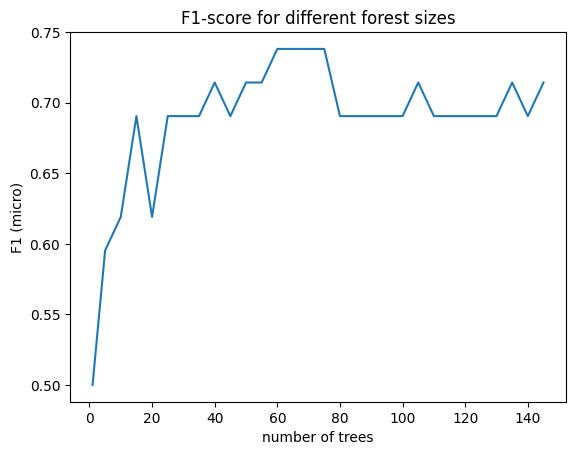

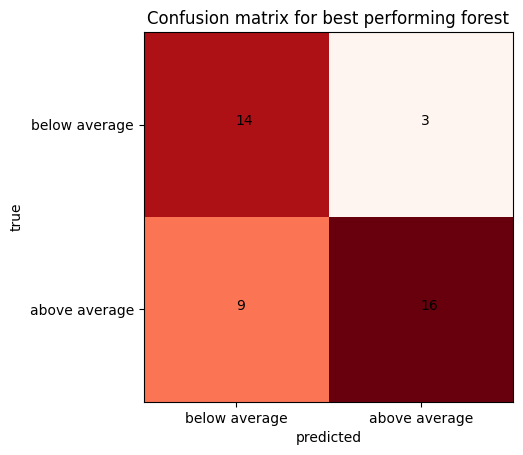

In [ ]:
# Implement your training and evaluation here.
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

number_of_trees = [1] + list(range(5, 150, 5))
f1scores = []
best_forest = None
for t in number_of_trees:
    np.random.seed()
    random_forest = RandomForestClassifier(t)
    random_forest.fit(X_train, y_train)
    print(random_forest)
    yhat = random_forest.predict(X_test)
    f1score = precision_recall_fscore_support(y_test, yhat, average="micro")[2]
    if f1score > max(f1scores + [0.0]):
        best_forest = random_forest
    f1scores.append(f1score)

best_forest_idx = np.argmax(f1scores)
best_f1score = f1scores[best_forest_idx]
print(
    f"Best F1-score {best_f1score:.02f} for number_of_trees = {number_of_trees[best_forest_idx]}."
)

fig, ax = plt.subplots()
ax.plot(number_of_trees, f1scores)
ax.set_xlabel("number of trees")
ax.set_ylabel("F1 (micro)")
ax.set_title("F1-score for different forest sizes")

fig, ax = plt.subplots()
cm = confusion_matrix(y_test, yhat)
ax.imshow(cm, cmap="Reds")
ax.set_xticks([0, 1])
ax.set_xticklabels(label_names)
ax.set_xlabel("predicted")
ax.set_yticks([0, 1])
ax.set_yticklabels(label_names)
ax.set_ylabel("true")
for i in range(2):
    for j in range(2):
        ax.text(i, j, cm[j, i])
ax.set_title("Confusion matrix for best performing forest");

## Task 1.1 (Assignment 7): Visualization of decision tree
visualize one of the decision trees from the `RandomForestClassifier` e.g. using [Graphviz](https://graphviz.org) and the [`export_graphviz`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html) method

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

rf = RandomForestClassifier(number_of_trees[best_forest_idx])
rf.fit(X_train, y_train)

for n in range(number_of_trees[best_forest_idx]):
    dot_data = export_graphviz(
        rf.trees[n],
        feature_names=[feature_names[idx] for idx in rf.tree_features[n]],
        class_names=label_names,
        filled=True,
        rounded=True,
        special_characters=True,
    )
    graph = graphviz.Source(dot_data)
    graph.render(f"trees_coffee/decision_tree_{n}")

## Task 2 (Assignment 7): Interpreting Random Forests

Implement the mean decrease of accuracy for the [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) `forest` to analyze learned attribute importances. Use the test set `X_test` and `y_test` as out-of-bag-samples. Permute the values of the assessed attribute by randomly shuffling the corresponding column. Plot the results to compare the importance of each feature. Discuss your results (are any importance values surprising, do the results make sense in the context of the task, ...).

Note: We have already trained the classifier and stored it in the variable `forest`. You only need to implement MDA and the plots for your results.

In [ ]:
import sklearn.ensemble
import sklearn.metrics

forest = sklearn.ensemble.RandomForestClassifier(60)
forest.fit(X_train, y_train)
prec, rec, f1, _ = sklearn.metrics.precision_recall_fscore_support(
    y_test, forest.predict(X_test), average="micro"
)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)

Precision: 0.7142857142857143
Recall: 0.7142857142857143
F1-score: 0.7142857142857143


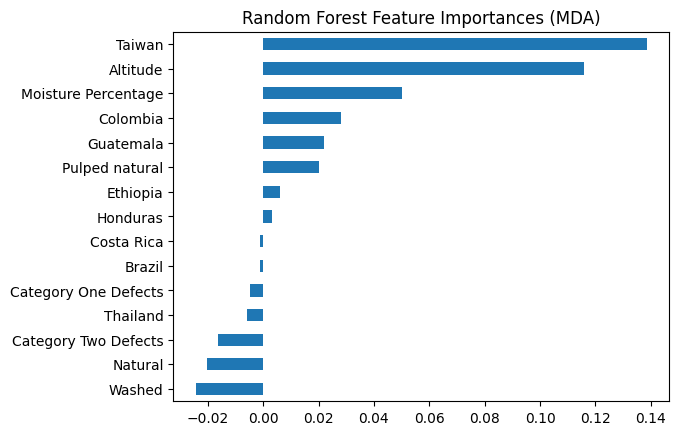

In [ ]:
import random


def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / y_true.size


def shuffle(x):
    return np.array(random.sample(list(x), x.size))


accuracy_orig = accuracy(y_test, forest.predict(X_test))

repeats = 100
num_attributes = X_test.shape[1]
mdas = []


for i in range(num_attributes):
    mda = 0.0
    # repeats ensure that the shift in accuracy does not occur by chance
    for j in range(repeats):
        X_shuffled = X_test.copy()
        X_shuffled[:, i] = shuffle(X_shuffled[:, i])
        accuracy_shuffled = accuracy(y_test, forest.predict(X_shuffled))
        mda += accuracy_orig - accuracy_shuffled
    mda /= float(repeats)
    mdas.append(mda)

mda = pd.Series(mdas, index=feature_names).sort_values(ascending=True)
fig, ax = plt.subplots()
ax = mda.plot.barh()
ax.set_title("Random Forest Feature Importances (MDA)");

## Task 2.1 (Assignment 7): Compare MDA and MDI
Compare the MDA results with the Mean Decrease of Impurity (MDA). You can use the property `feature_importances_` of the `forest` classifier. Discuss your results

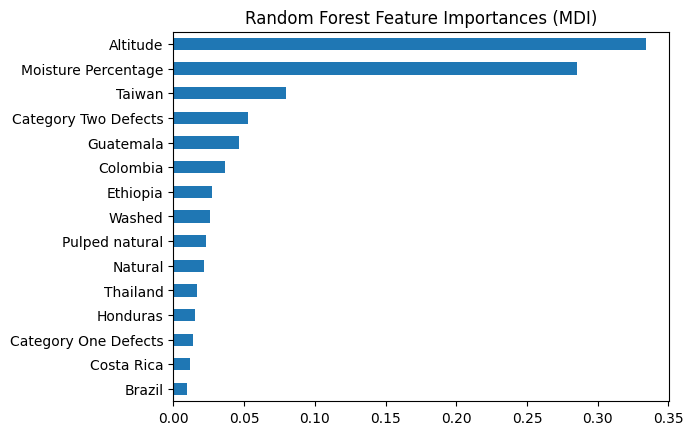

In [ ]:
mdi = pd.Series(forest.feature_importances_, index=feature_names).sort_values(
    ascending=True
)
fig, ax = plt.subplots()
ax = mdi.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)");

# Task 1 (Assignment 8): Discrete AdaBoost with Decision Stumps

In this task, you will implement the discrete AdaBoost algorithm using decision stumps as weak learners. Your training will run until either `n_learners` weak learners have been added or a perfect accuracy on the training data set is achieved. Use the function `initialize_decision_stumps` to create decision stumps, which you can train on your weighted data using `fit` and predict using `predict`. The decision stumps are instances of the class [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In addition, you will evaluate your model on the test data (`X_test`, `y_test`) using scikit-learn with the methods shown in the lecture (precision, recall, F1-score, confusion matrices, ...). Feel free to import any functions you need from scikit-learn for this purpose.

In [ ]:
def initialize_decision_stump():
    stump = DecisionTreeClassifier(criterion="entropy", max_depth=1)
    return stump


class AdaBoostClassifier(object):
    def __init__(self, n_learners):
        self.n_learners = n_learners
        self.learners = None
        self.weights = None
        self.coefficients = None

    def fit(self, X, y):
        self.learners = []
        self.coefficients = []
        self.weights = 1.0 / y.shape[0] * np.ones((y.shape[0],))

        for i in range(self.n_learners):
            learner = initialize_decision_stump()
            learner.fit(X, y, sample_weight=self.weights)
            yhat = learner.predict(X)
            error = self._weighted_error(y, yhat)
            expansion_coeff = np.log((1 - error) / error)

            self.weights = self.weights * np.exp(expansion_coeff * (y != yhat))
            self.learners.append(learner)
            self.coefficients.append(expansion_coeff)

        self.coefficients = np.array(self.coefficients)

    def predict(self, X):
        yhat = np.zeros((X.shape[0],))
        for learner, coef in zip(self.learners, self.coefficients):
            yhat += coef * (2 * learner.predict(X) - 1)
        yhat = ((np.sign(yhat) + 1) / 2).astype(int)
        return yhat

    def _weighted_error(self, y_true, y_pred):
        return np.sum((y_true != y_pred).astype(float) * self.weights) / np.sum(
            self.weights
        )


Best F1-score 0.79 for number_of_trees = 94.


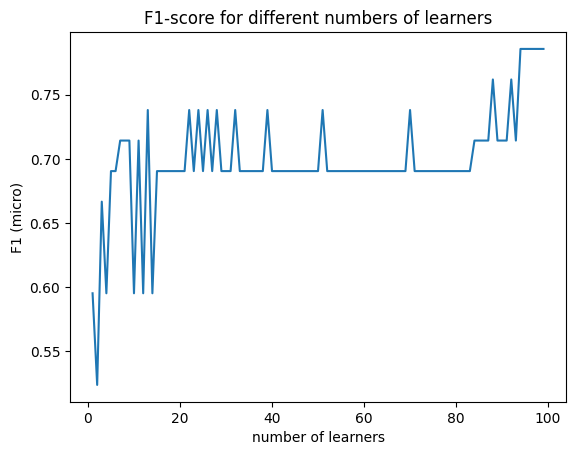

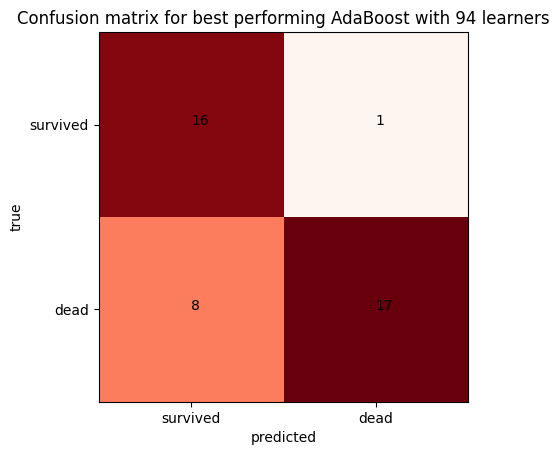

In [ ]:
# Implement your training and evaluation here.
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

number_of_learners = list(range(1, 100, 1))

f1scores = []
best_adaboost = None

for l in number_of_learners:
    np.random.seed(2020)

    adaboost = AdaBoostClassifier(l)
    adaboost.fit(X_train, y_train)
    yhat = adaboost.predict(X_test)
    f1score = precision_recall_fscore_support(y_test, yhat, average="micro")[2]
    if f1score > max(f1scores + [0.0]):
        best_adaboost = adaboost
    f1scores.append(f1score)

best_adaboost_idx = np.argmax(f1scores)
best_f1score = f1scores[best_adaboost_idx]
print(
    f"Best F1-score {best_f1score:.02f} for number_of_trees = {number_of_learners[best_adaboost_idx]}."
)

fig, ax = plt.subplots()
ax.plot(number_of_learners, f1scores)
ax.set_xlabel("number of learners")
ax.set_ylabel("F1 (micro)")
ax.set_title("F1-score for different numbers of learners")

fig, ax = plt.subplots()
cm = confusion_matrix(y_test, yhat)
ax.imshow(cm, cmap="Reds")
ax.set_xticks([0, 1])
ax.set_xticklabels(label_names)
ax.set_xlabel("predicted")
ax.set_yticks([0, 1])
ax.set_yticklabels(label_names)
ax.set_ylabel("true")
for i in range(2):
    for j in range(2):
        ax.text(i, j, cm[j, i])
ax.set_title(
    f"Confusion matrix for best performing AdaBoost with {number_of_learners[best_adaboost_idx]} learners"
);